In [1]:
import os

from tqdm.notebook import tqdm
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
import matplotlib.pyplot as plt

In [2]:
# muda o diretório atual para a pasta code onde temos o dataset salvo
os.chdir("../code")
os.getcwd()

'd:\\OneDrive\\monografia\\code'

In [3]:
df = pd.read_feather('scielo_dataset.feather')

Visualizando quais são os tipos dos textos

Criei essa lista com os tipos que se relacionam com ensino de ciências.

In [4]:
c = ['produtos e materiais didáticos',
     'pesquisa em ensino de física',
     'história da física e ciências afins',
     'desenvolvimento em ensino de física',
     'seção especial: informática no ensino de física',
     'história da física',
     'história da física e áreas afins',
     'seção especial: encontro " reflexões no ensino de física", sbf/mec ( brasília, 2005)']

Escolhendo os itens que o tipo está contido lista e o ano é maior que 2014

In [5]:
edu_df = df.query('seção in @c and ano > 2014')

In [6]:
def limpa_html(text_html) -> str:
     soup = BeautifulSoup(text_html, 'lxml', parse_only=SoupStrainer('div', attrs={'data-anchor': 'Text'}))

     # tags do título, citações, referências, equações e figuras foram removidas.
     remover = soup.find_all('h1') + soup.find_all('span', attrs={'class': 'ref'}) + \
               soup.find_all('div', attrs={'class':'row formula'}) + soup.find_all('div', attrs={'class': 'row fig'}) + \
               soup.find_all('math')

     for tag in remover:
          tag.decompose()

     return ' '.join(soup.text.lower().split())

In [7]:
textos = []
for arq in tqdm(edu_df['text_html']):
     textos.append(limpa_html(arq))

  0%|          | 0/323 [00:00<?, ?it/s]

# Análise NLP

In [8]:
import spacy
nlp = spacy.load("pt_core_news_lg")

from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS

In [9]:
my = {'p', 'fig', 'p.', 'cm', 'et', 'al', 't', 's', 'm', 'v', 'd', 'of', 'the',
      'eq', 'figura', 'b', 'pi', 'ref', 'km', 'kg', 'ii', 'iii', 'iv', 'xix', 'mm',
      'δ', 'in', 'and', 'x', 'f', 'r', 'u', 'i', 'g', 'h', 'l', 'y', 'z', 'w', 'k', 'q'}
stop = set(stopwords.words('portuguese')).union(STOP_WORDS).union(my)

In [10]:
# tokenização
documentos = []
for texto in tqdm(textos):
     doc = nlp(texto)
     temp = []
     for token in doc:
          if (token.orth_ not in stop or token.lemma_ not in stop) and token.is_alpha:
               temp.append(token.lemma_)
     documentos.append(temp)

  0%|          | 0/323 [00:00<?, ?it/s]

In [11]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Adiciona bigrams e trigrams para os documentos (só se aparecer 5 vezes ou mais).
bigram = Phrases(documentos, min_count=5)
for idx in range(len(documentos)):
     for token in bigram[documentos[idx]]:
          if '_' in token:  # se for um n-gram, adiciona no documento
               documentos[idx].append(token)

# cria o dicionário
dictionary = Dictionary(documentos)

# Filtra as palabras que ocorrem em menos de 30 documentos ou mais que 60% dos documentos.
dictionary.filter_extremes(no_below=30, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documentos]

# Set training parameters.
chunksize = 400
passes = 50
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time. Only in test mode.
random_seed = 99

# Make an index to word dictionary.
tempo = dictionary[0]
id2word = dictionary.id2token

In [12]:
medias = {}
for n in tqdm(range(8,14)):
     model = LdaModel(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=n,
          passes=passes,
          eval_every=eval_every,
          random_state=random_seed
     )
     
     cm_u_mass = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
     medias[n] = cm_u_mass.get_coherence()

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
medias

{8: -0.9835015128648643,
 9: -0.9950743362013112,
 10: -0.945479331897815,
 11: -0.9465998064844258,
 12: -0.9736575256431044,
 13: -0.967906700867723}

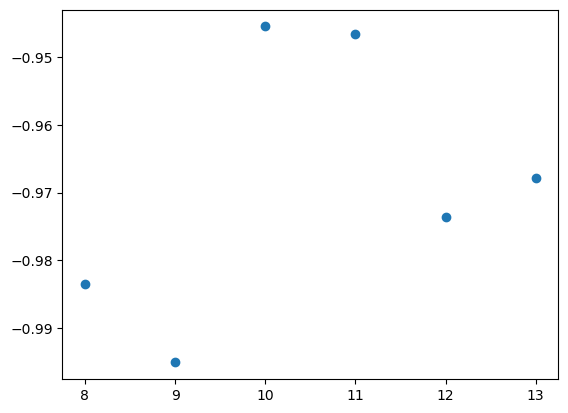

In [14]:
plt.scatter(medias.keys(), medias.values())
plt.show()

In [15]:
def printar_topicos(topics):
    for i, topic in enumerate(topics, start=1):
        print(f'Tópico {i} ({topic[1]:.4f}):')
        print('     ', end= '')
        for j, t in enumerate(topic[0], start=1):
            print(f'{t[1]} ({t[0]:.4f})', end = ' ')
            if j % 5 == 0:
                print('\n     ', end='')
        print()

In [16]:
model = LdaModel(
          corpus=corpus,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=10,
          passes=passes,
          eval_every=eval_every,
          random_state=99
     )

cm_u_mass = CoherenceModel(model = model, corpus = corpus, coherence = 'u_mass')
print('Coerência média:', cm_u_mass.get_coherence())

topics = model.top_topics(corpus)
printar_topicos(topics)

Coerência média: -0.945479331897815
Tópico 1 (-0.7537):
     disciplina (0.0156) aprendizagem (0.0113) conceitual (0.0080) avaliação (0.0074) turma (0.0074) 
     metodologia (0.0074) leitura (0.0072) educação (0.0069) ensino_médio (0.0056) categoria (0.0055) 
     questionário (0.0052) livro_didático (0.0050) social (0.0048) etapa (0.0048) avaliar (0.0046) 
     docente (0.0046) tarefa (0.0043) escola (0.0041) profissional (0.0040) licenciatura (0.0040) 
     
Tópico 2 (-0.8367):
     corpo (0.0154) quântico (0.0110) planeta (0.0091) terra (0.0079) obra (0.0075) 
     século (0.0067) visão (0.0064) universo (0.0062) mecânica (0.0061) lua (0.0061) 
     sol (0.0059) histórico (0.0059) parecer (0.0054) partícula (0.0053) matéria (0.0050) 
     esfera (0.0049) concepção (0.0048) história (0.0048) Newton (0.0046) ângulo (0.0044) 
     
Tópico 3 (-0.8551):
     item (0.0392) prova (0.0204) teste (0.0167) alternativa (0.0146) desempenho (0.0140) 
     acerto (0.0114) média (0.0110) ensino_m